# Document Classifier

Spam vs Ham text mining classifier

---

Jeff Shamp, John Kellogg CUMY MSDS 2021

In [3]:
import pandas as pd
import nltk 
import matplotlib.pyplot as plt
import seaborn as sns
import string

%matplotlib inline
#nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.metrics import classification_report, confusion_matrix

import warnings;
warnings.filterwarnings('ignore');

## Assignment

It can be useful to be able to classify new "test" documents using already classified "training" documents.  A common example is using a corpus of labeled spam and ham (non-spam) e-mails to predict whether or not a new document is spam.  Here is one example of such data:  UCI Machine Learning Repository: Spambase Data Set

For this project, you can either use the above dataset to predict the class of new documents (either withheld from the training dataset or from another source such as your own spam folder).

## Analysis

First, we are going to start with some basics about the files in the assignment. The data set covers sms messages with one column indicating spam and ham for wanted and unwanted messages.

In [6]:
messages = [line.rstrip() for line in open('SMSSpamCollection')]
print("Total number of messages:",len(messages))

Total number of messages: 5574


Next, we extract the length of each message, which is used later in classification (similar to the last assignment). In doing this step, we also have an added benefit of creating a nice way to visualize the data later in the report.

In [8]:
messages = pd.read_csv('SMSSpamCollection', sep='\t',
                           names=["label", "message"])
messages['length'] = messages['message'].apply(len)
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


We did find some interesting messages. For instance, the longest message is pretty funny. "Romeo" out here is writing essays about love. 

In [10]:
messages[messages['length'] == 910]['message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

As mentioned earlier, visualizing the length of the messages gives some interesting results.  The Total length of the messages (Spam/Ham combined) we have a bimodal right skew. When we break the messages apart, however, the messages seems to have an opposing skew.

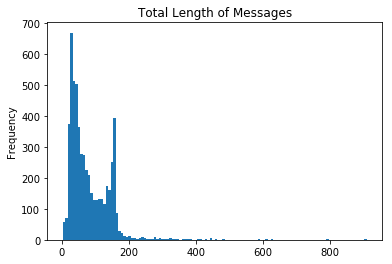

In [11]:
messages['length'].plot(bins=120, kind='hist') 
plt.title("Total Length of Messages")
plt.show()

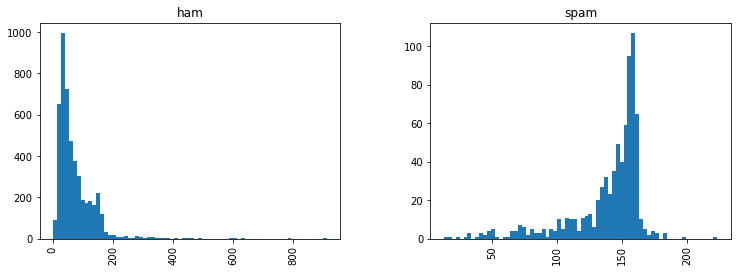

In [14]:
messages.hist(column='length', by='label', bins=70,figsize=(12,4))
plt.show()

If one looks at the X axis tick marks, we see most of both datasets fit in the same 0-200 length.  We can also see the second lower spike in the total graph is from the SPAM set.  There also seems to be a low spot for both values between the 50-125 length range. 

## Text Processing

We will use the sklearn API to process the text data by using a count vectorizer and TFIDF transfomer to numerically encode the text and surface the most important words in each message. The classifiers will then learn which aspects of the processed data will be most predictive.  We will use a Train/Test split of 80/20. 

In [15]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    nopunc = [char for char in mess if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [16]:
msg_train, msg_test, label_train, label_test = \
    train_test_split(messages['message'], 
                     messages['label'], 
                     test_size=0.2)

In [17]:
# Make the pipeline for iterative testing.
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', SVC())  # train on TF-IDF vectors w/ SVM classifier
])

In [18]:
#use pipeline to fit the training messages
pipeline.fit(msg_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x7fd2ecb2ea70>)),
                ('tfidf', TfidfTransformer()), ('classifier', SVC())])

In [19]:
predictions = pipeline.predict(msg_test)

In [20]:
print(classification_report(predictions,label_test))

              precision    recall  f1-score   support

         ham       1.00      0.98      0.99       997
        spam       0.83      0.98      0.90       118

    accuracy                           0.98      1115
   macro avg       0.91      0.98      0.94      1115
weighted avg       0.98      0.98      0.98      1115



In [22]:
print(confusion_matrix(predictions,label_test))

[[973  24]
 [  2 116]]


All in all pretty solid results, a weighted Average Accuracy of 98%. The model only produced two False Negatives.  We would want to minimize these on a spam filter.
